## Setup Environment

In [4]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sn
import dash
import dash_core_components as dcc
import dash_html_components as html
import plotly.graph_objects as go
import plotly.io as pio
from IPython.core.display import HTML
from matplotlib.pyplot import figure
from os import listdir
from os.path import isfile, join
import re

## Upload Data

In [5]:
path = 'C:\\Users\\steve\\OneDrive\\Desktop\\Github\\NFL Big Data Bowl\\0. Data'
allFiles = [f for f in listdir(path) if isfile(join(path, f))]

In [6]:
# Upload files
games = pd.read_csv("../0. Data/games.csv")
players = pd.read_csv("../0. Data/players.csv")
plays = pd.read_csv("../0. Data/plays.csv")

weeklyData = pd.DataFrame()

# Go through all weekly data and upload it
for file in allFiles:
    if "week" in file:
        tempWeek = pd.read_csv("../0. Data/"+file)
        tempWeek['week'] = re.findall(r'\d+', file)[0]
        weeklyData = pd.concat([weeklyData, tempWeek])

# merge with games to add home/away team indicators
weeklyData = weeklyData.merge(games[['gameId','homeTeamAbbr','visitorTeamAbbr']], on='gameId')

In [7]:
weeklyData.head()

,time,x,y,s,a,dis,o,dir,event,nflId,...,position,frameId,team,gameId,playId,playDirection,route,week,homeTeamAbbr,visitorTeamAbbr
0,2018-09-07T01:07:14.599Z,91.73,26.67,0.00,0.01,0.02,289.57,240.93,None,310.0,...,QB,1,away,2018090600,75,left,NaN,1,PHI,ATL
1,2018-09-07T01:07:14.599Z,88.89,36.47,0.01,0.01,0.01,105.63,66.66,None,79848.0,...,SS,1,home,2018090600,75,left,NaN,1,PHI,ATL
2,2018-09-07T01:07:14.599Z,91.35,44.16,0.02,0.03,0.01,290.45,16.86,None,2495454.0,...,WR,1,away,2018090600,75,left,HITCH,1,PHI,ATL
3,2018-09-07T01:07:14.599Z,86.31,22.01,0.09,0.42,0.01,70.12,168.91,None,2495613.0,...,FS,1,home,2018090600,75,left,NaN,1,PHI,ATL
4,2018-09-07T01:07:14.599Z,90.78,36.15,0.00,0.00,0.00,257.61,193.97,None,2533040.0,...,WR,1,away,2018090600,75,left,HITCH,1,PHI,ATL


## Data Wrangling

In [8]:
weeklyData.columns

Index(['time', 'x', 'y', 's', 'a', 'dis', 'o', 'dir', 'event', 'nflId',
       'displayName', 'jerseyNumber', 'position', 'frameId', 'team', 'gameId',
       'playId', 'playDirection', 'route', 'week', 'homeTeamAbbr',
       'visitorTeamAbbr'],
      dtype='object')

In [9]:
weeklyData['week'].value_counts().sort_index()

1      986022
10     964889
11     932240
12    1024868
13    1172517
14    1161644
15    1081222
16    1144037
17    1049265
2     1231793
3     1168345
4     1205527
5     1171908
6     1072563
7      982583
8     1001501
9      958464
Name: week, dtype: int64

In [10]:
# Only retain first frame of every play - get WR that lined up at the time of the snap
wrLinedUp = weeklyData[(weeklyData['position']=='WR')&(weeklyData['frameId']==1)]

# Get some descriptive stats and the 50th percentile of snaps played
print("Total Number of WR: ", wrLinedUp.displayName.value_counts().shape[0])
print("Average Snap per WR: ",wrLinedUp.displayName.value_counts().mean())
quantile = wrLinedUp.displayName.value_counts().quantile(0.50)
print("50th Percentile fo Snaps Played: ", quantile)

Total Number of WR:  227
Average Snap per WR:  231.71806167400882
50th Percentile fo Snaps Played:  201.0


In [11]:
# Get list of players that meet minimum snap requirement
wrLinedUpSnapCount = wrLinedUp.displayName.value_counts()
wrLinedUpSnapCountRetainPlayers = wrLinedUpSnapCount[wrLinedUpSnapCount>quantile].reset_index()['index'].tolist()

In [12]:
# Filter out dataframe with filtered list of players
wrLinedUpFiltered = wrLinedUp[wrLinedUp['displayName'].isin(wrLinedUpSnapCountRetainPlayers)]

In [13]:
wrLinedUpFiltered.head()

,time,x,y,s,a,dis,o,dir,event,nflId,...,position,frameId,team,gameId,playId,playDirection,route,week,homeTeamAbbr,visitorTeamAbbr
2,2018-09-07T01:07:14.599Z,91.35,44.16,0.02,0.03,0.01,290.45,16.86,None,2495454.0,...,WR,1,away,2018090600,75,left,HITCH,1,PHI,ATL
4,2018-09-07T01:07:14.599Z,90.78,36.15,0.00,0.00,0.00,257.61,193.97,None,2533040.0,...,WR,1,away,2018090600,75,left,HITCH,1,PHI,ATL
838,2018-09-07T01:09:09.700Z,50.05,38.03,0.00,0.00,0.00,256.84,103.45,None,2560854.0,...,WR,1,away,2018090600,146,left,HITCH,1,PHI,ATL
1514,2018-09-07T01:09:50.599Z,50.33,43.99,0.00,0.00,0.00,263.41,217.17,None,2495454.0,...,WR,1,away,2018090600,168,left,GO,1,PHI,ATL
1515,2018-09-07T01:09:50.599Z,50.77,9.61,0.00,0.00,0.01,282.02,199.57,None,2533040.0,...,WR,1,away,2018090600,168,left,SLANT,1,PHI,ATL


In [14]:
# Re format the dataframe to get the number of route ran by WR and route type
wrRoutePivot = wrLinedUpFiltered.groupby(['displayName','route']).size().reset_index()
wrRoutePivot.rename({0:'count'}, axis=1, inplace=True)

# Finalize the format and convert the raw number to percentage
wrRoutePivot = wrRoutePivot.pivot(index='displayName', columns='route', values='count').fillna(0)
wrRoutePivot = wrRoutePivot.div(wrRoutePivot.sum(axis=1), axis=0)

In [18]:
wrRoutePivot.head()

route,ANGLE,CORNER,CROSS,FLAT,GO,HITCH,IN,OUT,POST,SCREEN,SLANT,WHEEL,undefined
displayName,,,,,,,,,,,,,
A.J. Green,0.000000,0.056180,0.127341,0.011236,0.235955,0.123596,0.067416,0.078652,0.146067,0.037453,0.116105,0.0,0.0
Adam Humphries,0.002053,0.032854,0.067762,0.127310,0.092402,0.182752,0.168378,0.119097,0.078029,0.069815,0.059548,0.0,0.0
Adam Thielen,0.000000,0.068841,0.097826,0.028986,0.143116,0.253623,0.085145,0.166667,0.043478,0.034420,0.077899,0.0,0.0
Alex Erickson,0.000000,0.010417,0.114583,0.046875,0.307292,0.119792,0.088542,0.140625,0.057292,0.046875,0.067708,0.0,0.0
Allen Hurns,0.000000,0.018868,0.061321,0.018868,0.306604,0.254717,0.113208,0.066038,0.094340,0.018868,0.047170,0.0,0.0


<AxesSubplot:xlabel='route', ylabel='displayName'>

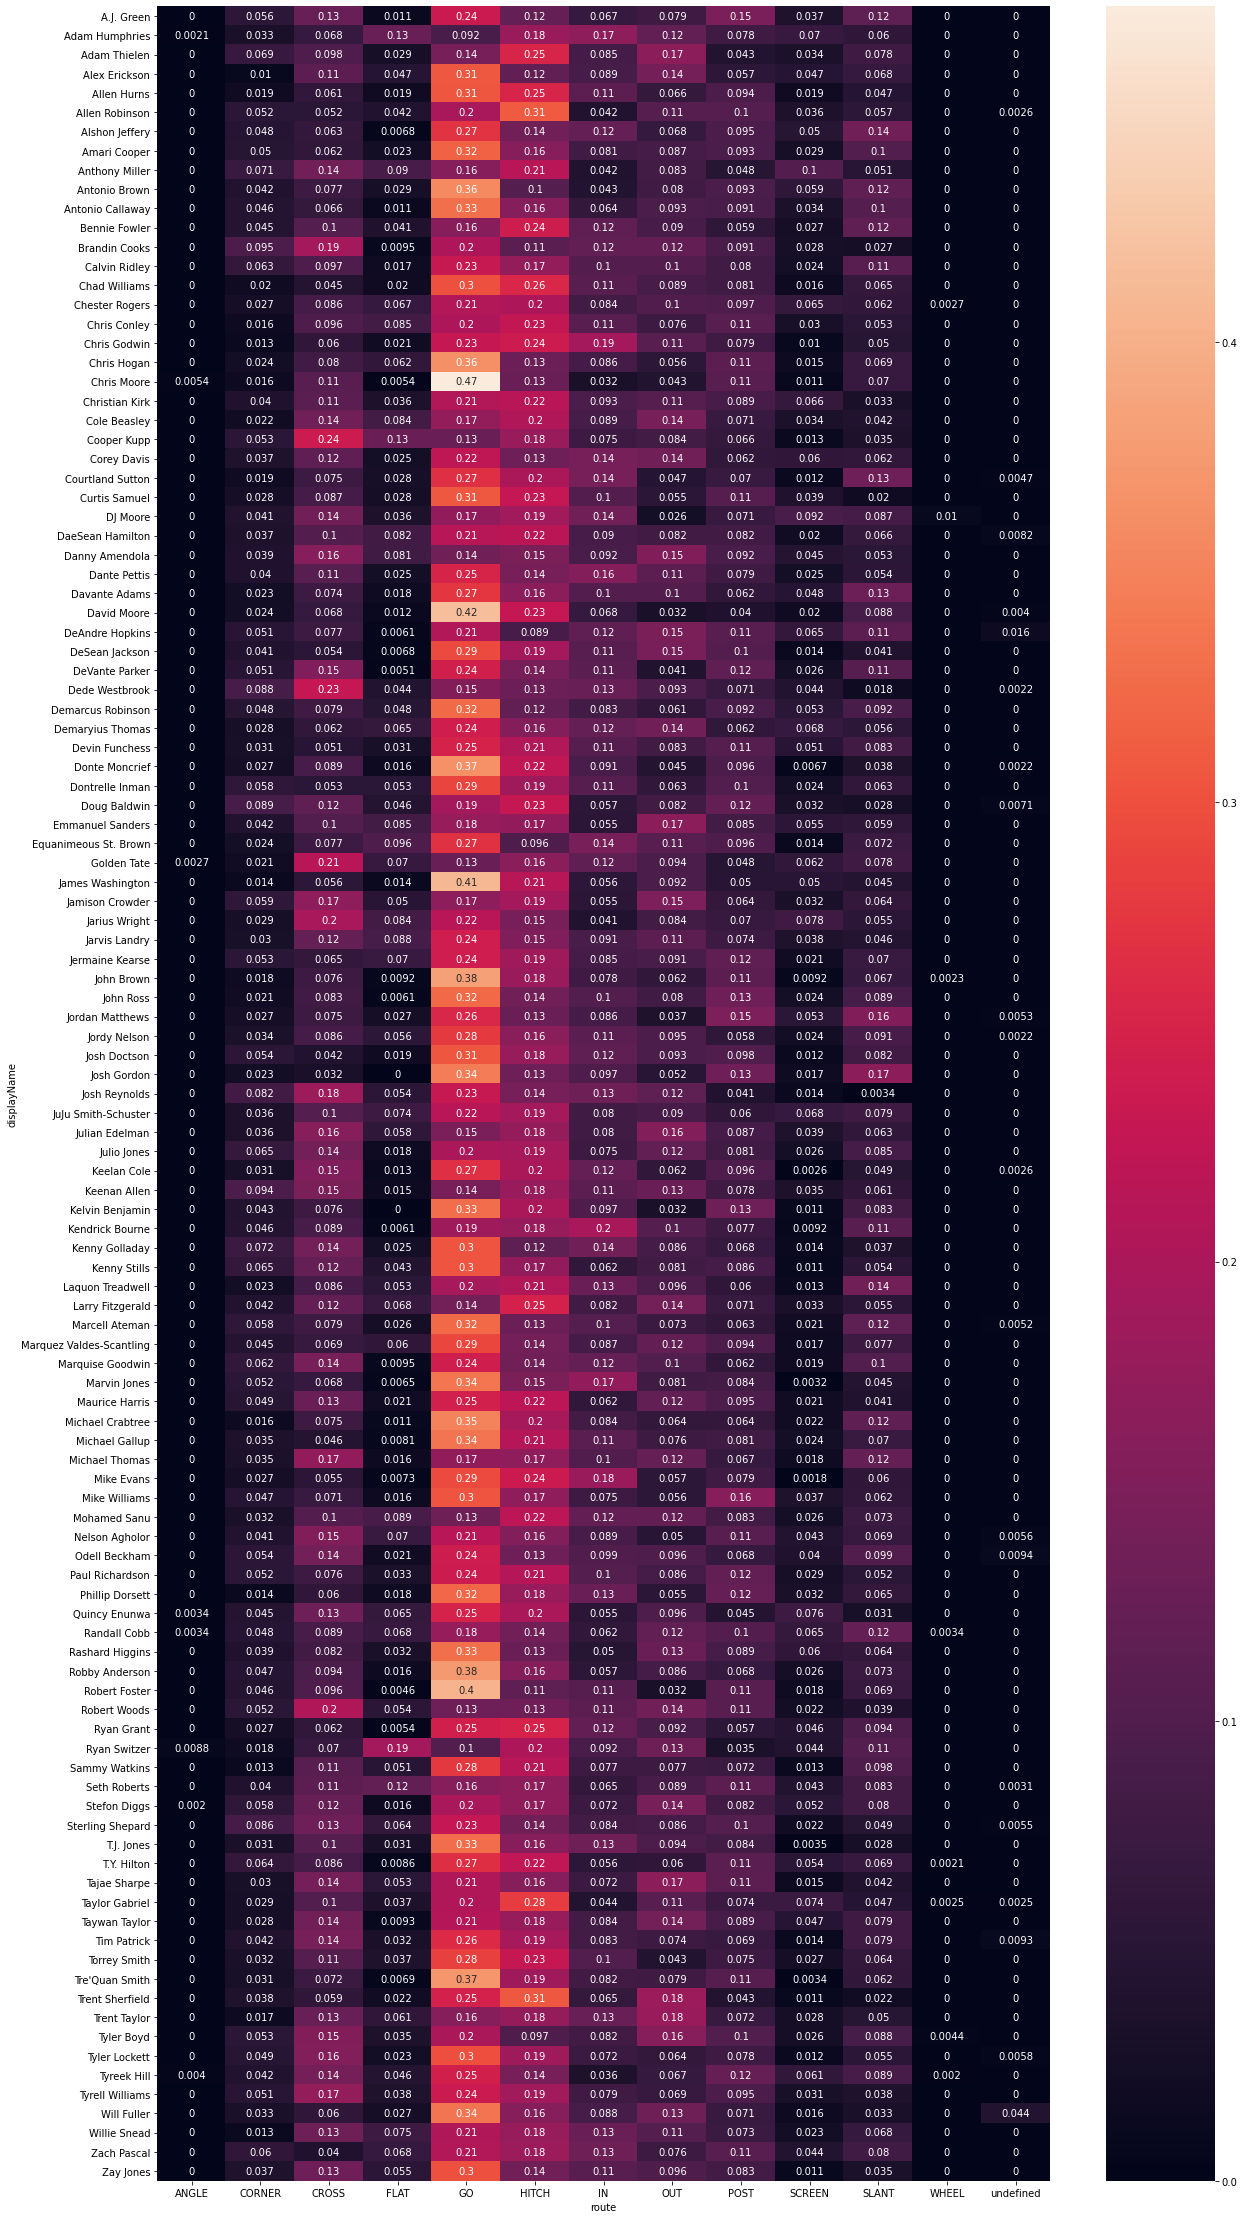

In [17]:
fig, ax = plt.subplots(figsize = (20, 40))
sn.heatmap(wrRoutePivot, annot = True)